# Подключение kaggle для Google Colab
Подробную информацию можно увидеть здесь (https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/) и здесь (https://www.kaggle.com/general/74235)

Для использования готовых моделей с числом эпох 5, 10 и 15 нужно в папку ./kaggle добавить папку с весами моделей hw_yaninya из репозитория

Подробные отчет можно увидеть в файле "отчет.*"

# Загрузка библиотек и объявление глобальных переменных

### Загрузка библиотек

In [1]:
import os
import time
import torch
import random
import shutil
import torchvision

import cv2 as cv
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from bs4 import BeautifulSoup
from google.colab import drive
from torchvision.ops import nms
from torch.optim import lr_scheduler
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

%matplotlib inline

### Объявление глобальных переменных

In [2]:
# 3 класса на определение + 1 класс на фон
NUM_CLASSES = 3 + 1
NUM_EPOCHS = 5
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 

MAIN_DIR = "/content/drive/MyDrive/kaggle"
DATA_DIR = "/content/drive/MyDrive/kaggle/data_face_mask"

ANNOTATION_DIR = "/content/drive/MyDrive/kaggle/data_face_mask/annotations"
ANNOTATION_DIR_TEST = "/content/drive/MyDrive/kaggle/data_face_mask/test_annotation"

IMAGE_DIR = "/content/drive/MyDrive/kaggle/data_face_mask/images"
IMAGE_DIR_TEST = "/content/drive/MyDrive/kaggle/data_face_mask/test_images"

In [3]:
# Настройка случайных чисел
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

# Может уменьшить время выполнения программы
torch.backends.cudnn.deterministic = True

# Подготовка данных для использования

### Выкачивание датасета из kaggle

In [4]:
# Здесь для загрузки нужен файл из kaggle-аккаунта для подключения к API
def download_data_from_kaggle(info=True):
    # Подключение к Google Disk
    drive.mount('/content/drive/')

    # Настройка путей
    os.getcwd()
    os.chdir(MAIN_DIR)
    os.environ['KAGGLE_CONFIG_DIR'] = MAIN_DIR

    # Выкачивание архива с данными
    if not os.path.exists(MAIN_DIR+"/face-mask-detection.zip"):
        !kaggle datasets download -d andrewmvd/face-mask-detection
    
    # Распаковка данных из архива
    if not os.path.exists(MAIN_DIR+"/data_face_mask"):
        !unzip -q /content/drive/MyDrive/kaggle/face-mask-detection.zip -d data_face_mask

    if info:
        print(
            f"Количество картинок: {len(os.listdir(path=IMAGE_DIR))}",
            f"Количество описаний картинок: {len(os.listdir(path=ANNOTATION_DIR))}",
            f"Содержимое папки kaggle {os.listdir(path=MAIN_DIR)}", sep="\n"
        )

### Создание выборок

In [5]:
def create_test_directory_with_files(info=True):
    len_images = len(os.listdir(IMAGE_DIR))
    len_annotation = len(os.listdir(ANNOTATION_DIR))
    assert len_images == len_annotation, "Количество описаний и ихображений не совпадает"
    
    if info:
        print("Количество изображений всего ", len_images)
        print("Количество описаний изображений всего ", len_annotation)
        print("Создание тестовых директорий для изображений и описаний")

    if not os.path.exists(IMAGE_DIR_TEST):
        !mkdir ./data_face_mask/test_images
    if not os.path.exists(ANNOTATION_DIR_TEST):
        !mkdir ./data_face_mask/test_annotation

    idx_test = random.sample(range(len_images), int(len_images/5))

    if info:
        print("Заполнение тестовых директорий для изображений и описаний")

    for img in np.array(sorted(os.listdir(IMAGE_DIR)))[idx_test]:
        shutil.move(IMAGE_DIR+"/"+img, IMAGE_DIR_TEST+"/"+img)
    for annot in np.array(sorted(os.listdir(ANNOTATION_DIR)))[idx_test]:
        shutil.move(ANNOTATION_DIR+"/"+annot, ANNOTATION_DIR_TEST+"/"+annot)

    if info:
        print("Количество описаний изображений в тренировочной выборке ", 
              len(os.listdir(ANNOTATION_DIR)))
        print("Количество изображений в тренировочной выборке ", 
              len(os.listdir(IMAGE_DIR)))
        print("Количество описаний изображений в тестовой выборке ", 
              len(os.listdir(ANNOTATION_DIR_TEST)))
        print("Количество изображений в тестовой выборке ", 
              len(os.listdir(IMAGE_DIR_TEST)))

### Работа с данными 

In [6]:
# Создает границы бокса
def generate_box(obj):
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    return [xmin, ymin, xmax, ymax]

# Объявление номеров для каждого вида объекта
def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    elif obj.find('name').text == "without_mask":
        return 3

# Парсит файлы и изображения
def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        return target

# Отрисовка изображений
def plot_image_from_output(img, annotation):
    img = img.cpu().permute(1,2,0)
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),
                                     (xmax-xmin),
                                     (ymax-ymin),
                                     linewidth=2,
                                     edgecolor='g',
                                     facecolor='none')
        
        elif annotation['labels'][idx] == 2 :
            rect = patches.Rectangle((xmin,ymin),
                                     (xmax-xmin),
                                     (ymax-ymin),
                                     linewidth=2,
                                     edgecolor='b',
                                     facecolor='none')
            
        else :
            rect = patches.Rectangle((xmin,ymin),
                                     (xmax-xmin),
                                     (ymax-ymin),
                                     linewidth=2,
                                     edgecolor='r',
                                     facecolor='none')

        ax.add_patch(rect)
    plt.show()

In [7]:
# Просмотр картинок из датасета
def plot_image_from_train_data(num_images=1):

    images_paths = [IMAGE_DIR+'/'+i for i in os.listdir(IMAGE_DIR)[:num_images]]
    annotation_paths = [i.replace('png', 'xml').replace('images', 'annotations') for i in images_paths]

    fig, ax = plt.subplots(num_images, figsize=(10, 8))
    
    for i in range(num_images):
        img = cv.imread(images_paths[i])[:,:,::-1]
        annotation = generate_target(annotation_paths[i])
        if num_images == 1:
            ax.imshow(img)
        else:
            ax[i].imshow(img)
        for idx in range(len(annotation["boxes"])):
            xmin, ymin, xmax, ymax = annotation["boxes"][idx]

            if annotation['labels'][idx] == 1 :
                rect = patches.Rectangle((xmin,ymin),
                                     (xmax-xmin),
                                     (ymax-ymin),
                                     linewidth=2,
                                     edgecolor='g',
                                     facecolor='none')
        
            elif annotation['labels'][idx] == 2 :
                rect = patches.Rectangle((xmin,ymin),
                                     (xmax-xmin),
                                     (ymax-ymin),
                                     linewidth=2,
                                     edgecolor='b',
                                     facecolor='none')
            
            else:
                rect = patches.Rectangle((xmin,ymin),
                                     (xmax-xmin),
                                     (ymax-ymin),
                                     linewidth=2,
                                     edgecolor='r',
                                     facecolor='none')
            if num_images == 1:
                ax.add_patch(rect)
            else:
                ax[i].add_patch(rect)
    plt.show()

In [8]:
# Создание директорий с содержимым для тестовой и тренировочной выборок
class MaskDataset(object):
    def __init__(self, transforms, path):
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))

    def __getitem__(self, idx): 
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        if 'test' in self.path:
            label_path = os.path.join(ANNOTATION_DIR_TEST+"/", file_label)
        else:
            label_path = os.path.join(ANNOTATION_DIR+"/", file_label)
        img = Image.open(img_path).convert("RGB")
        target = generate_target(label_path)
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self): 
        return len(self.imgs)

def collate_fn(batch):
    return tuple(zip(*batch))

# Работа с моделью model_fasterrcnn_resnet50

### Загрузка модели

In [9]:
# Сборка предобученной модели на датасете COCO
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

### Тренировка модели

In [10]:
# Обучение модели
def train_model(model, optimizer, scheduler, data_loader, num_epochs=5):
    print('----------------------train start--------------------------')
    for epoch in range(num_epochs):
        start = time.time()
        model.train()
        scheduler.step()
        i = 0    
        epoch_loss = 0
        for imgs, annotations in data_loader:
            i += 1
            imgs = list(img.to(DEVICE) for img in imgs)
            annotations = [{k: v.to(DEVICE) for k, v in t.items()} for t in annotations]
            loss_dict = model(imgs, annotations) 
            losses = sum(loss for loss in loss_dict.values())        

            optimizer.zero_grad()
            losses.backward()
            optimizer.step() 
            epoch_loss += losses
        print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')
    print('-----------------------train end---------------------------')

### Сохранение модели

In [11]:
def save_model(model, model_name='model_fasterrcnn_resnet50_5ep.pt'):
    if not os.path.exists(MAIN_DIR+"/hw_yaninya/"+ model_name):
        torch.save(model.state_dict(), MAIN_DIR+"/hw_yaninya/" + model_name)
        print('Модель сохранена')
    else:
        raise FileExistsError(f'Модель {model_name} уже существует в директории!')

def load_model(model, model_name='model_fasterrcnn_resnet50_5ep.pt'):
    if not os.path.exists(MAIN_DIR+"/hw_yaninya/" + model_name):
        raise FileExistsError(f'Модели {model_name} не существует в директории {MAIN_DIR}!')
    else:
        print("Модель загружена")
        return model.load_state_dict(torch.load(MAIN_DIR+"/hw_yaninya/" + model_name))
        

def delete_model(model_name='model_fasterrcnn_resnet50_5ep.pt'):
    if not os.path.exists(MAIN_DIR+"/hw_yaninya/" + model_name):
        raise FileExistsError(f'Модели {model_name} не существует в директории {MAIN_DIR}!')
    else:
        os.remove(MAIN_DIR+"/hw_yaninya/" + model_name)
        print("Модель удалена")

# Метрики качества

Под метриками понимаются функции/формулы, по которым оценивается качество модели-детектора. Обычно для измерения качества работы детектора используют поклассовые Precision, Recall, F1-меру и mean Average Precision (mAP). Подробнее про них можно послушать в [видеолекции 2018 года](https://www.youtube.com/watch?v=ewkSI2cuyoQ&list=PL0Ks75aof3ThkitsZbUOEQg7Ybl5kB_s3&index=24).

Необходимо самостоятельно реализовать функции, вычисляющие поклассовые Precision и Recall. На вход функциям поступают веса модели и выборка, на которой нужно измерить метрики. На выходе $-$ таблица с precision и recall для каждого класса.

> Результат пункта $-$ реализованные функции метрик для задачи детектирования, позволяющие оценить качество работы модели на выборке. Выборка/даталоадер является аргументом функций.

## Постобработка предсказанных значений

Есть идеи для двух вариантов: 
- Использовать встроенный метод torchvision.ops.nms. Соответсвующая функция clear_predict_boxes_with_nms
- Использовать следующую идею: 
    - Находится максимальное значение метрики IoU из всех возможных пар боксов на каждой картинке из тренировочной выборки
    - Для предсказанных моделью боксов считается метрика IoU для всех возможных пар; при значении большем чем найденное в предыдущем пункте отбрасывается то, на котором меньше оценка принадлежности к классу. Таким образом, уходят те боксы, которые предсказывают один и тот же объект на картинке. При значении IoU больше чем максимально возможное в выборке получаем неразличимые боксы для объекта



In [12]:
# Поиск максимального значения для пересечения двух боксов разных объектов
# Это значение будет использоваться уже для постобработки предсказанных боксов
# Так как данные из одной выборки
def find_max_iou_for_real_images(loader):
    max_iou = 0

    # Цикл по даталоадеру
    for imgs, annotations in loader:
        # Цикл по боксам с координатами
        for i in range(len(annotations)):
            # Расчет IoU для попарных боксов
            for box_first in range(len(annotations[i]['boxes'])):
                for box_second in range(box_first+1, len(annotations[i]['boxes'])):
                    iou_new = torchvision.ops.box_iou(
                        torch.Tensor([annotations[i]['boxes'][box_first].numpy()]),
                        torch.Tensor([annotations[i]['boxes'][box_second].numpy()])).numpy()[0][0]
                    if max_iou < iou_new:
                        max_iou = iou_new
    return max_iou


# start = time.time()
# iou_train = find_max_iou_for_real_images(loader=data_loader)
# end = time.time()
# print("IOU для тренировочных данных ", iou_train)
# print("Время на расчеты ", end-start)

In [13]:
# Очистка предсказанных боксов по уровню попарных пересечений
# Используется метрика nms для выделения наилучших боксов
def clear_predict_boxes_with_nms(max_iou_cross, predictions_loader):
    pred_box = []
    pred_scores = []
    pred_classes = []

    # Цикл по даталоадеру
    for sample_new in predictions_loader:
        # Цикл по сэмплам 
        for img in sample_new:
            # Расчет IoU для попарных боксов
            pred_nms = nms(boxes = img['boxes'], 
                           scores = img['scores'], 
                           iou_threshold=max_iou_cross)
            pred_box.append(img['boxes'][pred_nms.cpu().numpy()])
            pred_classes.append(img['labels'][pred_nms.cpu().numpy()])
            pred_scores.append(img['scores'][pred_nms.cpu().numpy()])
    print("Предсказания очищены с помощью NMS")
    return [pred_box, pred_classes, pred_scores]

In [14]:
# Очистка предсказанных боксов по уровню попарных пересечений
# Используется метрика IoU для нахождения боксов с большим общим пересечением
def clear_predict_boxes_with_iou(predictions_loader, max_iou_cross):
    pred_box = []
    pred_scores = []
    pred_classes = []

    # Цикл по даталоадеру
    for sample_new in predictions_loader:
        # Цикл по сэмплам 
        for img in sample_new:
            droped_ind = []
            # Цикл по всем боксам для изображения
            for box_first in range(len(img['boxes'])):
                # Цикл по оставшимся боксам
                for box_second in range(box_first+1, len(img['boxes'])):
                    iou_new = torchvision.ops.box_iou(
                            torch.Tensor([img['boxes'][box_first].numpy()]),
                            torch.Tensor([img['boxes'][box_second].numpy()])).numpy()[0][0]
                    # Последовательно запоминаем индексы повторяющихся боксов
                    if max_iou_cross <= iou_new:
                        if img['scores'][box_first] > img['scores'][box_second]:
                            droped_ind.append(box_second)
            new_ind = np.delete(
                    np.linspace(0, len(img['boxes'])-1, len(img['boxes'])), 
                    droped_ind)
            pred_box.append(img['boxes'][new_ind])
            pred_classes.append(img['labels'][new_ind])
            pred_scores.append(img['scores'][new_ind])
    return [pred_box, pred_classes, pred_scores]

## Выравнивание количества рельных объектов с боксами и количества предсказанных моделью объектов с боксами на картинке
После получения предсказаний возможны следующие ситуации:
 - Количество предсказанных объектов меньше чем количество реальных объектов. Это значит, что модель не смогла найти часть объектов
 - Количество предсказанных объектов больше чем количество реальных объектов. Это значит, что модель нашла несуществующие объекты
 - Количество предсказанных объектов равно количеству реальных объектов. В оптимистичном случае - было найдено все необходимое, в пессмистичном случае - возможны различные варианты некачественного предсказания

Для обработки данных вариантов и нужна эта часть

In [15]:
# Приведение к соответствию количества предсказанных и реальных изображений
# Заменить добавление номера класса в значениях словаря на 0/1, тк ключи - номера классов
def alignment_samples_real_predict(real_labels, clear_labels, predict_scores):
    error_predict_image = 0
    pred_image_class = {1: [], 2: [], 3: []}
    real_image_class = {1: [], 2: [], 3: []}
    pred_image_score = {1: [], 2: [], 3: []}

    for i in range(len(real_labels)):
        # Создание словаря с ключами из классов изображений и их количеством в реальной разметке
        dict_key, dict_value = np.unique(real_labels[i].numpy(), return_counts=True)
        dict_sample_real = {key: [1 for _ in range(value)] for (key, value) in zip(dict_key, dict_value)}

        # Создание словаря с ключами из классов изображений и их количеством в предсказанной разметке
        # Передаются данные после очистки и прошедшие порог по score
        dict_key, dict_value = np.unique(clear_labels[i].cpu().numpy(), return_counts=True)
        dict_sample_pred = {key: [1 for _ in range(value)] for (key, value) in zip(dict_key, dict_value)}

        # Создание словаря с ключами из классов изображений и их оценками в предсказанной разметке
        dict_sample_pred_score = {1: [], 2: [], 3: []}
        for cl, sc in zip(clear_labels[i].cpu().numpy(), predict_scores[i].cpu().numpy()):
            dict_sample_pred_score[cl].append(sc)

        # Цикл по всем меткам классов
        for i in [1, 2, 3]:
            # Проверка на существование такого класса в тренировочной выборке
            if (i in dict_sample_real):
                # Проверка на существование такого класса в предсказанных данных
                if (i in dict_sample_pred):
                    len_real = len(dict_sample_real[i]) 
                    len_pred = len(dict_sample_pred[i])
                    # Дополняем 0 до равного размера
                    if len_real > len_pred:
                        dict_sample_pred[i] += [0 for _ in range(len_real-len_pred)]
                        dict_sample_pred_score[i] += [0 for _ in range(len_real-len_pred)]
                    # Удаляем наименее качественные предсказания
                    elif len_real < len_pred:
                        dict_sample_pred[i] = dict_sample_pred[i][:-abs(len_real-len_pred)]
                        dict_sample_pred_score[i] = dict_sample_pred_score[i][:-abs(len_real-len_pred)] 
                # Есть реальные данные, но нет предсказания => заполняем 0
                else:
                    dict_sample_pred[i] = [0 for _ in range(len(dict_sample_real[i]))]
                    dict_sample_pred_score[i] = [0 for _ in range(len(dict_sample_real[i]))]

                pred_image_class[i] += dict_sample_pred[i]
                real_image_class[i] += dict_sample_real[i]
                pred_image_score[i] += dict_sample_pred_score[i]
            else:
                if (i in dict_sample_pred):
                    error_predict_image += len(dict_sample_pred.pop(i))
    print(
        "Количество реальных объектов каждого класса в тестовой выборке: 1 - {}, 2 - {}, 3 - {}".format(
            len(real_image_class[1]), len(real_image_class[2]), len(real_image_class[3])
        )
    )
    return real_image_class, pred_image_class, error_predict_image, pred_image_score

## Расчет метрик recall, precision и f1_score

In [16]:
# Функция для красивого вывода
def pretty_print(metrica: str, values: list, weights: list):
    print("{:90}".format('\033[1m' + f"Расчет метрики {metrica}: " + '\033[0m'))
    print("-"*100)
    print("| {:30} | {:30} | {:30} |".format("Значение для 1 класса", "Значение для 2 класса", "Значение для 3 класса"))
    print("|", "-"*30, '+', "-"*30, '+', "-"*30, "|")
    print("| {:30} | {:30} | {:30} |".format(values[0], values[1], values[2]))
    print("|", "-"*96, "|")
    # Считаем средневзвешанную оценку для метрики
    print("| {:96} |".format(f"Среднее значение: %.4f" % (
        (values[0]*weights[0] + values[1]*weights[1] + values[2]*weights[2])/(sum(weights))
        )))
    print("-"*100)

In [17]:
# Расчет метрик precision_score, recall_score и f1_score
# y_pred/y_real - содержат бинарные значения, 
# y_real - все единицы, тк берется из размеченных данных
# y_pred - 1 при существовании такого бокса с классом, 0 при отсутствии бокса
def useful_metrics(y_pred, y_real, scores):
    pr_sc = []
    weights = []
    for i in [1, 2, 3]:
        if y_pred[i]:
            pr_sc.append(precision_score(y_pred=y_pred[i], y_true=y_real[i], 
                                         average='macro', zero_division=0))
        else:
            pr_sc.append(0)
        weights.append(sum(y_real[i]))
    pretty_print(metrica='precision_score', values=pr_sc, weights=weights)

    rec_sc = []
    for i in [1, 2, 3]:
        if y_pred[i]:
            rec_sc.append(recall_score(y_pred=y_pred[i], y_true=y_real[i], 
                                         average='macro', zero_division=0))
        else:
            rec_sc.append(0)
    pretty_print(metrica='recall_score', values=rec_sc, weights=weights)

    f1_sc = []
    for i in [1, 2, 3]:
        if y_pred[i]:
            f1_sc.append(f1_score(y_pred=y_pred[i], y_true=y_real[i], 
                                  average='macro', zero_division=0))
        else:
            f1_sc.append(0)
    pretty_print(metrica='f1_score', values=f1_sc, weights=weights)

## Расчет метрики mean Average Precision
Выделена данная метрика в отдельную часть в связи с достаточно объемным расчетом:
- первая функция считает метрику для одного класса
- вторая функция считает метрику для всех классов и готовит данные для первой



1) Вычисление Average Precision для одного класса   
Берутся все предсказания модели (координаты предсказанных боксов) и ранжируются по уровню уверенности модели в каждом боксе. Далее считается IoU найденных боксов с размеченными боксами при уровне max_IoU (описан выше): >= считаем что верно найден объект, < объект не найден. Получется таблица вида - ранг бокса и бинарный ответ по метрике IoU с порогом. Далее начиная сверху вниз с первой строки считаются метрики precision и recall с последующим добавлением по одной строке. После данных операций получаем расширенную таблицу - ранг бокса, бинарный ответ по метрике IoU, precision и recall.

2) Расчет метрики mean Average Precision для одного класса    
Строим график зависимости precision(recall) для наглядного представления. Для расчета среднего разбиваем всю шкалу recall на 11 значений - [0, 0.1, ..., 0.9, 1] (в идеальном представлении, разбиения могут меняться). Вычисляется среднее значение в данных точках в некоторой окрестности. После чего выбирается прямоугольники с найденными координатами с округлением вверх. Например, если был скачок в значении precision, то дополняются все значения до прямоугольника вверх. Наконец вычисляется общая площадь под получившейся фигурой. Полученное значение и является mean Average Precision для данного класса

Информация брал здесь:
- https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173
- https://ml.i-neti.ru/map-mean-average-precision/
- https://neerc.ifmo.ru/wiki/index.php?title=%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0_%D0%BD%D0%B0%D1%85%D0%BE%D0%B6%D0%B4%D0%B5%D0%BD%D0%B8%D1%8F_%D0%BE%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D0%BE%D0%B2_%D0%BD%D0%B0_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B8
- https://towardsdatascience.com/map-mean-average-precision-might-confuse-you-5956f1bfa9e2
- https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173


In [18]:
def count_average_precision(scores: list, iou_binary: list, label_ind: int):
    # Данные должны быть одного размера
    if ((len(scores) != len(iou_binary)) or (len(iou_binary)==0) or 
        (len(scores)==0)):
        print("Проблема с переданными данными")
        return 0

    # Нужно сначала отсортировать входные данные
    result = np.column_stack([scores, iou_binary])
    result.view('f8,f8').sort(order=['f0'], axis=0)
    result = result[::-1]

    # Создание и заполнение массивов для метрик recall и precision
    sample_size = result.shape[0]
    recall = np.zeros(sample_size)
    precision = np.zeros(sample_size)
    for i in range(sample_size):
        recall[i] = sum(result[:, 1][:(i+1)])/sum(result[:, 1])
        precision[i] = sum(result[:, 0][:(i+1)])/(i+1)

    # Добавление левой и правой границ для метрик recall и precision
    if recall[0] != 0.:
        recall = np.concatenate(([0.], recall))
        precision = np.concatenate(([1.], precision))
    if recall[recall.shape[0]-1] != 1.:
        recall = np.concatenate((recall, [1.]))
        precision = np.concatenate((precision, [0.]))
    assert precision.shape[0] == recall.shape[0], "Размерности не совпадают"

    # Получение аппроксимаций для метрик recall и precision
    recall_mean = recall.copy()
    precision_mean = precision.copy()
    for i in range(precision_mean.size-1, 0, -1):
        precision_mean[i-1] = np.maximum(precision_mean[i-1], precision_mean[i])

    # Расчет average precision
    i = np.where(recall_mean[1:] != recall_mean[:-1])[0]
    ap = np.sum((recall_mean[i + 1] - recall_mean[i]) * precision_mean[i + 1])

    # Отрисовка графиков
    plt.figure(figsize=(12, 8))
    plt.grid(color='0.75')
    plt.title(f"Precision-recall curve for label {label_ind}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.plot(recall, precision, 'g-o', label='Предсказанные значения')
    plt.plot(recall_mean, precision_mean, 'b--', label='Аппроксимация для нахождения average precision')
    plt.legend(title='Значение линий')
    return ap


# iou = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
# scores = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
# # scores = np.array([0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0, 0])
# # iou = np.array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0])
# av_pre = count_average_precision(scores=scores, iou_binary=iou, label_ind=5)
# print(av_pre)

In [19]:
# Создание словаря с бинарными ответами по метрике IoU
# Хочется передавать аналогично скоры уверенности модели в предсказаниии объекта
def count_average_precision_all(clear_scores, clear_boxes, clear_labels,
                                real_boxes, max_iou_cross, real_size):
    find_iou_scores = {1: [], 2: [], 3: []}
    find_pred_scores = {1: [], 2: [], 3: []}
    result = []
    
    # Проход по всем изображениям
    for i in range(len(real_boxes)):
        # Проход по всем реальным объектам на изображении
        for r_img in real_boxes[i]:
            fl = 0
            # Проход по всем предсказанным объектам на изображениям
            for p_img in range(len(clear_boxes[i])):
                iou_new = torchvision.ops.box_iou(
                            torch.Tensor([r_img.numpy()]),
                            torch.Tensor([clear_boxes[i][p_img].cpu().numpy()])).numpy()
                # Условие говорит о неразличимости двух боксов
                # Сильное предположение - это боксы одного и того же объекта
                # Предположение основано на том, как считалось само значение max_iou_cross
                if iou_new >= max_iou_cross:
                    fl = 1
            if len(clear_labels[i]) > 0:
                find_iou_scores[clear_labels[i][p_img].item()].append(fl)
                find_pred_scores[clear_labels[i][p_img].item()].append(clear_scores[i][p_img].item())

    # Если модель нашла не все реальные объекты, то в предсказанные моделью скоры  
    # добавляется 0, а в найденные значения 1, тоесть объект есть, предсказания нет
    for i in [1, 2, 3]:
        raz = real_size[i-1] - sum(find_iou_scores[i])
        if  raz > 0:
            find_pred_scores[i] += [0 for _ in range(raz)]
            find_iou_scores[i] += [1 for _ in range(raz)]
        # Теперь идет расчет метрики
        result.append(count_average_precision(scores=find_pred_scores[i], 
                                              iou_binary=find_iou_scores[i],
                                              label_ind=i))
        
    pretty_print(metrica='mean Average Precision', values=result, weights=real_size)
    return result

## Единая/Главная функция для расчета всех метрик
Реализуются следующие этапы:
- Модель на тестовой выборке делает предсказания
- Проводится постобработка полученных данных
- Считаются метрики и рисуются графики

Над чем пришлось довольно долго думать при реализации:
- 1) В разметке (real) указано M боксов для выборки с повторениями n1 из N возможных классов. Причем возможно нахождение нескольких объектов одного и того же класса.   
- 2) В предсказанной разметке L боксов для выборки с повторениями n2 из N возможных классов. Причем для одного объекта возможно существование нескольких боксов и отсутствие бокса для одного из объекта, тоесть 1 объект на картинке выделяется и для него несколько боксов, а другой трудно выделимый и его не нашли. Идем дальше:   
  - 2.1) Для нахождения данной ситуации можно добавить сравнение полного количества реальных/размеченных изображений с предсказанными - $\frac{number\ predict\ objects} {number\ real\ objects} *100\% $;   
  - 2.2) При n1=n2 - найдены все объекты и нужно выбрать наиболее вероятные боксы; при n1>n2 - найдены не все обекты, разность дополняется (N+1) классом для расчета метрик и нужно выбрать n2 боксов под найденные объекты; при n1<n2 - были предсказаны несуществующие объекты, которые необходимо отбросить с использованием n1 и сведению этого случаю к двум предыдущим.
  - 2.3) Выделение наилучших боксов: находится количество объектов каждого класса для фиксированного уровня threshold, выбираются лучшие боксы для каждого класса равным предыдущим найденым значениям, расчитываются необходимые метрики.  
- 3) PS: пока нет ясности как разграничить одинаковые боксы для одного и того же объекта, предложенный вариант несколько улучшает варинт прямого использования без разделения на классы 
- 4*) Считать IoU для предсказанных боксов и при уровне пересечения, например 0.8 отбрасывать один из сравниваемых объектов. Для этого необходимо посмотреть IoU на тренировочных значениях, что поможет определиться с порогом.
- 5*) Использовать Non-Max Suppression с некоторым уровнем. После этого идет расчет метрик и количественное сравнение для реальных и предсказанных объектов

Были реализованы некоторые идеи по этим пунктам

In [20]:
# Предсказания для одного сэмпла
def make_prediction_sample(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []
        for idx, score in enumerate(preds[id]['scores']):
            # Если уверенность модели высокая, то добавляем данные
            if score > threshold : 
                idx_list.append(idx)
        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]
    return preds

# Предсказания для всех (некоторого количества) сэмплов
def make_prediction_full(data_loader, model, score_rate=0.5, num_samples=3):
    pred_lab = []
    real_lab = []
    fl = 0
    with torch.no_grad(): 
        for imgs, annotations in data_loader:
            imgs = list(img.to(DEVICE) for img in imgs)
            pred = make_prediction_sample(model, imgs, score_rate)
            pred_lab.append(pred)
            real_lab.append(annotations)
            fl += 1
            if fl >= num_samples:
                break
    print("Количество батчей в выборке: ", len(pred_lab))
    return pred_lab, real_lab

In [21]:
# Общая функция для расчета метрик
def calculation_metrics(test_loader, train_loader, model, score_rate=0.5):
    # Предсказание модели для нескольких сэмплов
    # Внутри сэмпла несколько картинок
    # Внутри картинки может быть несколько объектов
    start = time.time()
    print("Модель делает предсказания")
    predict_data, real_data = make_prediction_full(model=model,
                                                   num_samples=170, 
                                                   data_loader=test_loader,
                                                   score_rate=score_rate)

    # Получение информации о классах и боксах
    real_boxes = []
    real_labels = []
    # Итерация по сэмплам
    for sample_new in real_data:
        # Итерация по изображениям
        for img in sample_new:
            real_boxes.append(img['boxes'])
            real_labels.append(img['labels'])
    print("Общее количество изображений в выборке: ", len(real_labels))

    # Хотим чтобы предсказанные значения для боксов не пересекались сильнее
    # чем размеченные боксы для тренировки модели
    print("Считается максимальное значение IoU пересечений на тренировочных данных: ")
    max_iou_cross = find_max_iou_for_real_images(loader=test_loader)
    print(max_iou_cross)

    # Очистка данных с помощью метода non max supression
    print("Очистка данных с помощью NMS")
    clear_boxes, clear_labels, clear_scores = clear_predict_boxes_with_nms(predictions_loader=predict_data,
                                                                            max_iou_cross=max_iou_cross)
    
    # Выравнивание по размеру выборок данных с нижней границей
    print("\033[1m"+"Расчет качества модели"+"\033[0m")
    info = alignment_samples_real_predict(real_labels=real_labels,
                                          clear_labels=clear_labels, 
                                          predict_scores=clear_scores)
    
    # Расчет метрик recall, f1_score, precision_score
    useful_metrics(y_pred=info[1], y_real=info[0], 
                   scores=info[3])
    
    # Расчет метрики mean Average Precision
    count_average_precision_all(clear_scores=clear_scores, 
                                clear_boxes=clear_boxes, 
                                clear_labels=clear_labels, 
                                real_boxes=real_boxes,
                                max_iou_cross = max_iou_cross, 
                                real_size=[len(info[0][1]), len(info[0][2]), len(info[0][3])])
    print("Количество False Positive срабатываний ", info[2])
    print(f"Потраченное время на расчеты: %.4f c" % (time.time()-start))

# Место сбора и запуска кода

При повторном запуске части кода, отвечающего за создание выборок и датадоадеров, подготовке данных стоит учитывать, что данные заново не будут загружены, но произойдет снова деление данных на валидационную и тестовую выборки. Таким образом тренировочная выборка уменьшится, а тестовая увеличится

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
 98% 391M/398M [00:05<00:00, 67.6MB/s]
100% 398M/398M [00:05<00:00, 78.8MB/s]
Количество картинок: 853
Количество описаний картинок: 853
Содержимое папки kaggle ['kaggle.json', 'hw_yaninya', 'face-mask-detection.zip', 'data_face_mask']
Количество изображений всего  853
Количество описаний изображений всего  853
Создание тестовых директорий для изображений и описаний
Заполнение тестовых директорий для изображений и описаний
Количество описаний изображений в тренировочной выборке  683
Количество изображений в тренировочной выборке  683
Количество описаний изображений в тестовой выборке  170
Количество изображений в тестовой выборке  170


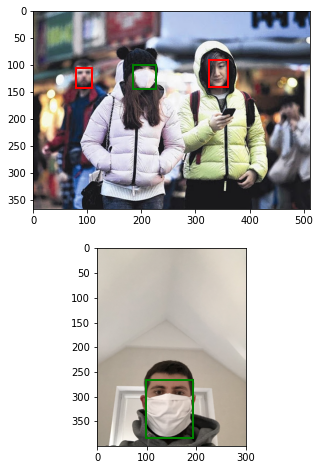

Размер тренировочной выборки  683
Размер валидационной выборки  170


In [22]:
# Загрузка данных из платформы kaggle
download_data_from_kaggle()

# Создание тренировочной и тестов директорий с файлами
create_test_directory_with_files()

# Просмотр изображений
plot_image_from_train_data(num_images=2)

# Обработка картинок
data_transform = transforms.Compose([transforms.ToTensor()])

# Создание тренировочного и тестового датасетов
train_dataset = MaskDataset(data_transform, path=IMAGE_DIR+'/')
test_dataset = MaskDataset(data_transform, path=IMAGE_DIR_TEST+'/')
print("Размер тренировочной выборки ", len(train_dataset))
print("Размер валидационной выборки ", len(test_dataset))

# Создание тренировочного и тестового даталоадеров
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, collate_fn=collate_fn)

In [23]:
# Подготовка модели
model_fasterrcnn_resnet50 = get_model_instance_segmentation(NUM_CLASSES)
model_fasterrcnn_resnet50

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [24]:
# Обучение модели
print(DEVICE)
model_fasterrcnn_resnet50.to(DEVICE)
params = [p for p in model_fasterrcnn_resnet50.parameters() if p.requires_grad]
optimizer_ft = optim.Adam(params, lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=0.1)

train_model(model_fasterrcnn_resnet50, optimizer_ft, exp_lr_scheduler, 
            data_loader=train_data_loader, num_epochs=NUM_EPOCHS)


cuda
----------------------train start--------------------------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch : 1, Loss : 75.07567596435547, time : 844.318336725235
epoch : 2, Loss : 47.557395935058594, time : 844.8109309673309
epoch : 3, Loss : 41.250099182128906, time : 842.4765069484711
epoch : 4, Loss : 30.103713989257812, time : 841.616857290268
epoch : 5, Loss : 26.61714744567871, time : 841.5658595561981
-----------------------train end---------------------------


In [25]:
# При необходимости есть возможность использовать фукнкции для работы с моделью
model_name='model_fasterrcnn_resnet50_5ep.pt'

save_model(model_name=model_name, model=model_fasterrcnn_resnet50)

# model_fasterrcnn_resnet50 = get_model_instance_segmentation(NUM_CLASSES)
model_fasterrcnn_resnet50.load_state_dict(torch.load(MAIN_DIR+"/hw_yaninya/" + model_name))
model_fasterrcnn_resnet50.to(DEVICE)

# delete_model(model_name='model_fastrcnn_resnet50_5.pt')

Модель сохранена


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Target :  tensor([3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 1, 1, 3,
        3, 1])


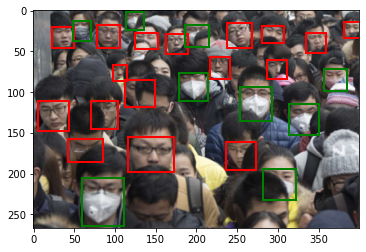

Prediction :  tensor([1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3,
        3, 3, 3, 3, 1, 3], device='cuda:0')


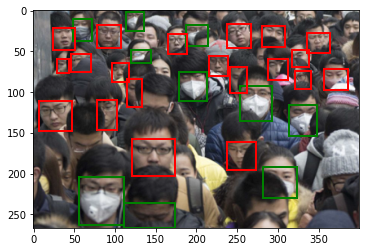

In [26]:
# Просмотр изображений с предсказанными классами и боксами
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

with torch.no_grad(): 
    # batch size of the test set = 2
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(DEVICE) for img in imgs)
        pred = make_prediction(model_fasterrcnn_resnet50, imgs, 0.5)
        break

_idx = 1
print("Target : ", annotations[_idx]['labels'])
plot_image_from_output(imgs[_idx], annotations[_idx])
print("Prediction : ", pred[_idx]['labels'])
plot_image_from_output(imgs[_idx], pred[_idx])

Модель делает предсказания
Количество батчей в выборке:  43
Общее количество изображений в выборке:  170
Считается максимальное значение IoU пересечений на тренировочных данных: 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  app.launch_new_instance()


0.7058824
Очистка данных с помощью NMS
Предсказания очищены с помощью NMS
Расчет качества модели
Количество реальных объектов каждого класса в тестовой выборке: 1 - 654, 2 - 28, 3 - 158
Расчет метрики precision_score:                                                   
----------------------------------------------------------------------------------------------------
| Значение для 1 класса          | Значение для 2 класса          | Значение для 3 класса          |
| ------------------------------ + ------------------------------ + ------------------------------ |
|                            0.5 |                            0.0 |                            0.5 |
| ------------------------------------------------------------------------------------------------ |
| Среднее значение: 0.4833                                                                         |
----------------------------------------------------------------------------------------------------
Расчет метрики recall_sc

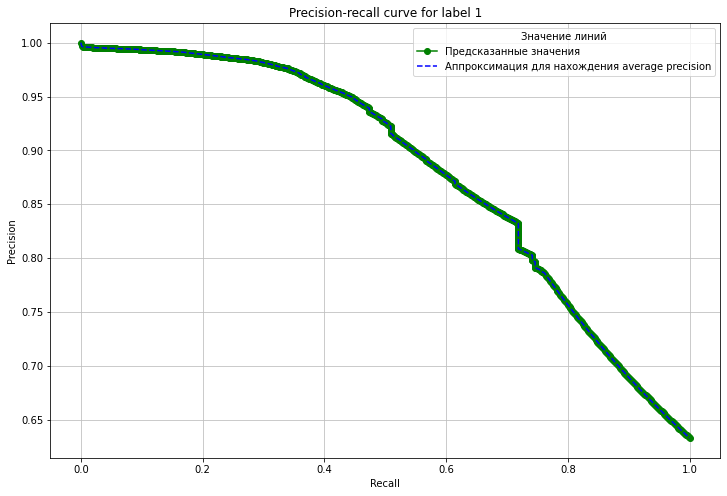

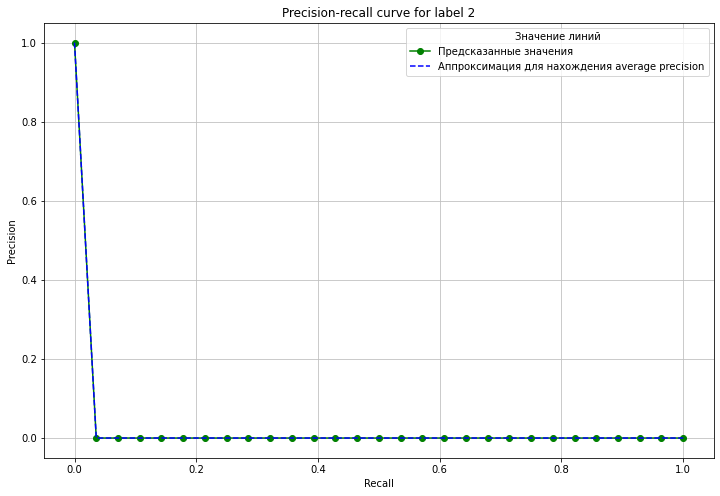

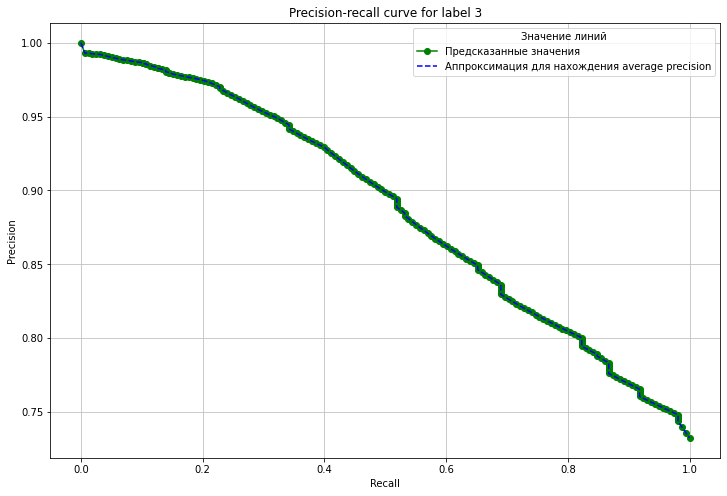

In [27]:
# Получение небольшого отчета
calculation_metrics(test_loader=test_data_loader, train_loader=train_data_loader, 
                    score_rate=0.5, model=model_fasterrcnn_resnet50)